# Introduction
How to open and understand the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

## Basic information
1. Hyperspectral data:
    1. `hsi_path` contains path to hyperspectral masked numpy arrays containing hyperspectral data that underwent masking (i.e., the field area is masked, whereas all irrelevant areas are not masked)
    2. The name of the file (e.g., _'1989.npz'_) refers to the index of the corresponding training sample in the ground-truth table.
2. Ground-truth data:
    1. `gt_path` contains path to ground truth .csv file.
    2. Additionally, `wavelength_path` contains the mapping between a band number and the corresponding wavelength.


In [2]:
hsi_path = '/Users/nathanzlomke/Downloads/train_data/train_data/1570.npz'
gt_path = '/Users/nathanzlomke/Downloads/train_data/train_gt.csv'
wavelength_path = '/Users/nathanzlomke/Downloads/train_data/wavelengths.csv'

In [3]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [4]:
gt_df[gt_df['sample_index']==1570]

,sample_index,P,K,Mg,pH
1570,1570,47.9,165.0,181.0,6.8


## Displaying one hyperspectral band

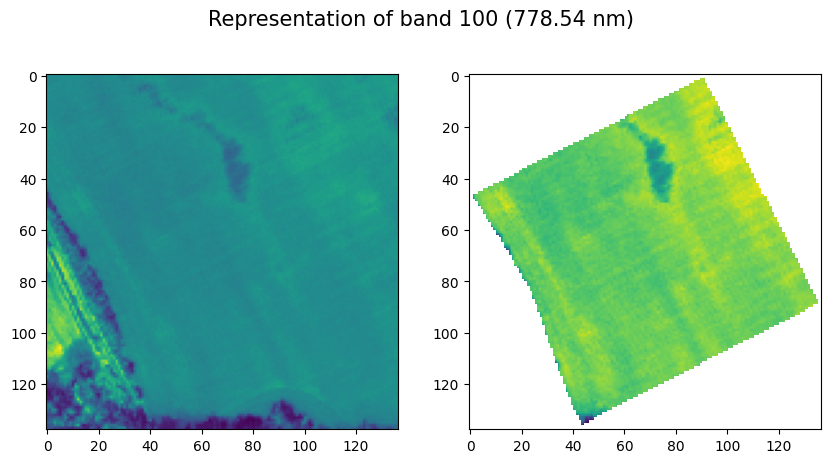

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]

with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)

axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

## Displaying the aggregated spectral curve for a field

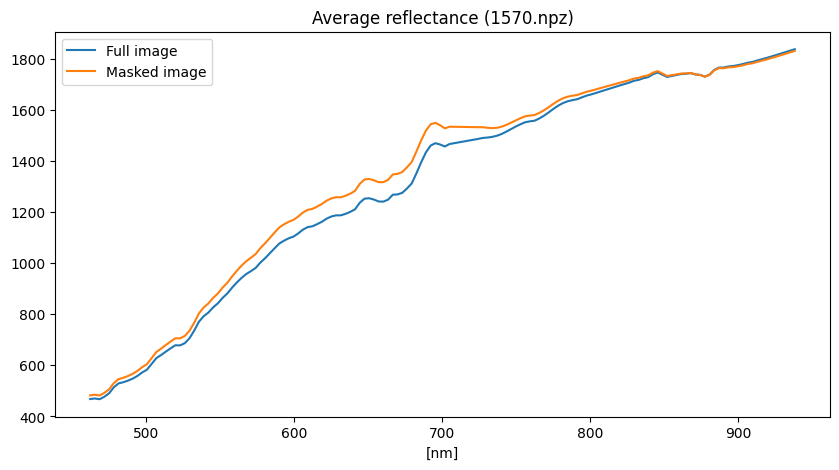

In [6]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

# Generating baseline solution

In [7]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


## Load the data

In [8]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels

X_train = load_data("/Users/nathanzlomke/Downloads/train_data/train_data") #X_train = load_data("train_data")
y_train = load_gt(gt_path) #y_train = load_gt("train_gt.csv")
X_test = load_data("/Users/nathanzlomke/Downloads/test_data") #X_test = load_data("test_data")

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Train data shape: (1732, 150)
Test data shape: (1154, 150)


In [9]:
X_train.shape

(1732, 150)

# Data Pre-processing

### Data Exploration

In [10]:
from sklearn.preprocessing import PowerTransformer

power_transformer = PowerTransformer(method='yeo-johnson')
X_train = power_transformer.fit_transform(X_train)
X_test = power_transformer.fit_transform(X_test)

### Scaling the X and Y variables

# Building a LightGBM Model

### Importing Library

In [11]:
#Split up the target variables per model
y_train = pd.DataFrame(y_train)
y_train = y_train.rename(columns={0:'P',1:'K',2:'Mg',3:'pH'})
P_train = y_train['P']
K_train = y_train['K']
Mg_train = y_train['Mg']
pH_train = y_train['pH']

### Phosphorus Model

In [12]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
P_test=[]
# Create LightGBM datasets for training and testing
train_data = lgb.Dataset(X_train, label=P_train)
test_data = lgb.Dataset(X_test, label=P_test)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'objective': ['regression'],  # Multi-output regression task
    'num_leaves': [3,7,12],
    'learning_rate': [0.01,0.03,0.05],
    'n_estimators': [10,20,40],
    'max_depth': [5,7,9],
    'reg_alpha':[0.1,0.3,0.5],
    'reg_lambda':[0.1,0.2,0.3],
    'feature_fraction': [0.6,0.75,0.9],  
    'bagging_fraction': [0.6,0.75,0.9],
    'bagging_freq':[1,3,5,7,10],
    'min_child_samples': [20,50,100],
    'boosting_type': ['gbdt', 'dart','goss']  
}

# Create the LGBMRegressor model
model = lgb.LGBMRegressor()

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, scoring='neg_mean_squared_error', cv=50, n_jobs=-1, random_state=42, verbose=0)

# Fit the RandomizedSearchCV
random_search.fit(X_train, P_train)

# Get the best estimator from RandomizedSearchCV
P_best_model = random_search.best_estimator_

# Make predictions on the test data
P_pred = P_best_model.predict(X_test)


#Best Parameters: {'objective': 'regression', 'num_leaves': 31, 'n_estimators': 100, 'learning_rate': 0.05}
#Best Parameters: {'objective': 'regression', 'num_leaves': 5, 'n_estimators': 25, 'learning_rate': 0.03}
#Best Parameters: {'reg_lambda': 0.1, 'reg_alpha': 0.5, 'objective': 'regression', 'num_leaves': 3, 'n_estimators': 10, 'min_child_samples': 100, 'max_depth': 9, 'learning_rate': 0.03, 'feature_fraction': 0.9, 'boosting_type': 'gbdt', 'bagging_freq': 3, 'bagging_fraction': 0.75}
#Best Parameters: {'reg_lambda': 0.2, 'reg_alpha': 0.3, 'objective': 'regression', 'num_leaves': 3, 'n_estimators': 40, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.03, 'feature_fraction': 0.9, 'boosting_type': 'dart', 'bagging_freq': 5, 'bagging_fraction': 0.75}


In [21]:
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'reg_lambda': 0.2, 'reg_alpha': 0.3, 'objective': 'regression', 'num_leaves': 3, 'n_estimators': 40, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.03, 'feature_fraction': 0.9, 'boosting_type': 'dart', 'bagging_freq': 5, 'bagging_fraction': 0.75}


In [22]:
P_pred=pd.DataFrame(P_pred)
P_pred.columns = ["P"]


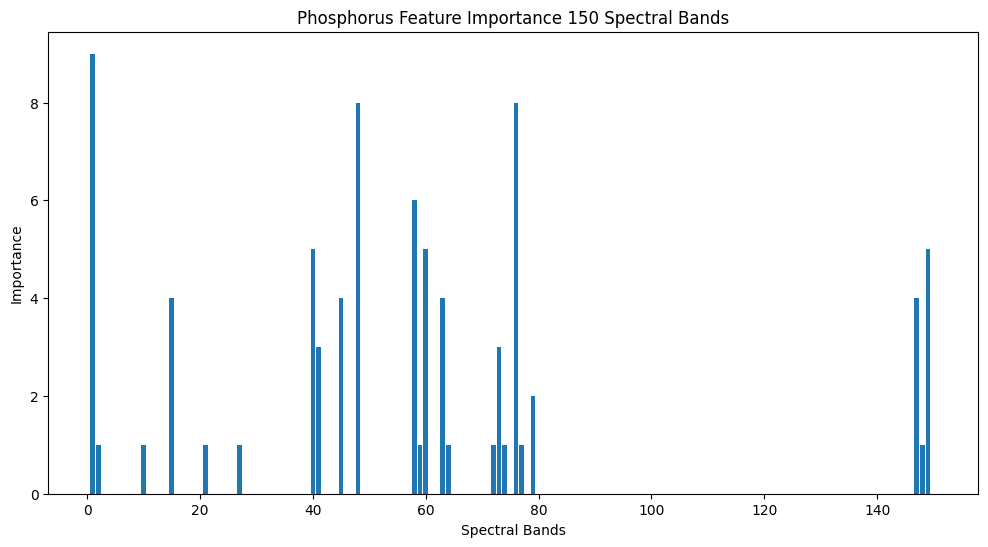

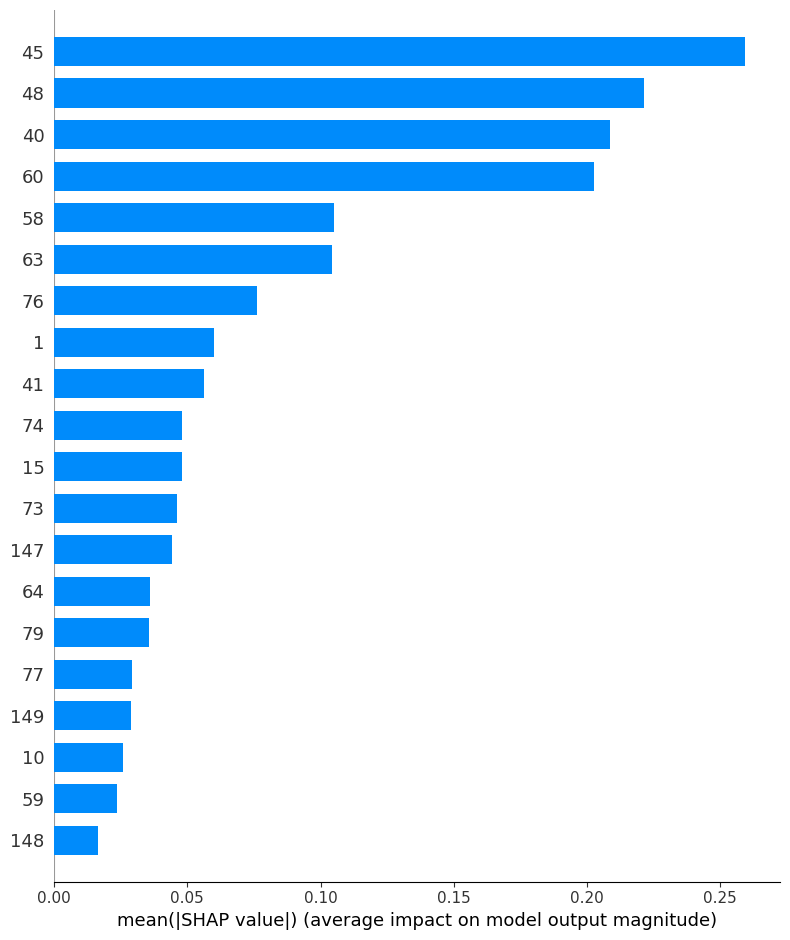

In [238]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample data for 150 spectral bands (you should replace this with your actual data)
spectral_bands = np.arange(1, 151)
P_feature_importance = P_best_model.feature_importances_  # Replace with your actual spectral band values

# Create a bar chart for feature importance
plt.figure(figsize=(12, 6))
plt.bar(spectral_bands, P_feature_importance, width=0.8, align='center')
plt.xlabel('Spectral Bands')
plt.ylabel('Importance')
plt.title('Phosphorus Feature Importance 150 Spectral Bands')
plt.show()

# Create an explainer for your model (replace 'P_best_model' with your actual model)
explainer = shap.Explainer(P_best_model)

# Calculate SHAP values for a specific instance (X_test[0] in this example)
input_data = X_test[0]

# Check the shape and reshape if necessary
if len(input_data.shape) == 1:
    input_data = input_data.reshape(1, -1)  # Reshape to 2D
shap_values = explainer.shap_values(input_data)

# Visualize the summary plot for feature importance
shap.summary_plot(shap_values, input_data, feature_names=spectral_bands, plot_type="bar")

# Visualize the force plot for the expected value (no need for [0])
shap.initjs()  # Required to display the plot in Jupyter Notebook
shap.force_plot(explainer.expected_value, shap_values, input_data)





### Potasium Model (K)

In [ ]:
K_test=[]
# Create LightGBM datasets for training and testing
train_data = lgb.Dataset(X_train, label=K_train)
test_data = lgb.Dataset(X_test, label=K_test)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'objective': ['regression'],  # Multi-output regression task
    'num_leaves': [3,7,12],
    'learning_rate': [0.01,0.03,0.05],
    'n_estimators': [10,20,40],
    'max_depth': [5,7,9],
    'reg_alpha':[0.1,0.3,0.5],
    'reg_lambda':[0.1,0.2,0.3],
    'feature_fraction': [0.6,0.75,0.9],  
    'bagging_fraction': [0.6,0.75,0.9],
    'bagging_freq':[1,3,5,7,10],
    'min_child_samples': [20,50,100],
    'boosting_type': ['gbdt', 'dart','goss']  
}

# Create the LGBMRegressor model
model = lgb.LGBMRegressor()

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, scoring='neg_mean_squared_error', cv=50, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV
random_search.fit(X_train, K_train)

# Get the best estimator from RandomizedSearchCV
K_best_model = random_search.best_estimator_

# Make predictions on the test data
K_pred = K_best_model.predict(X_test)


#Best Parameters: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'objective': 'regression', 'num_leaves': 12, 'n_estimators': 40, 'min_child_samples': 100, 'max_depth': 9, 'learning_rate': 0.01, 'feature_fraction': 0.6, 'boosting_type': 'dart', 'bagging_freq': 7, 'bagging_fraction': 0.9}


In [98]:
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'objective': 'regression', 'num_leaves': 12, 'n_estimators': 40, 'min_child_samples': 100, 'max_depth': 9, 'learning_rate': 0.01, 'feature_fraction': 0.6, 'boosting_type': 'dart', 'bagging_freq': 7, 'bagging_fraction': 0.9}


In [99]:
K_pred=pd.DataFrame(K_pred)
K_pred.columns = ["K"]

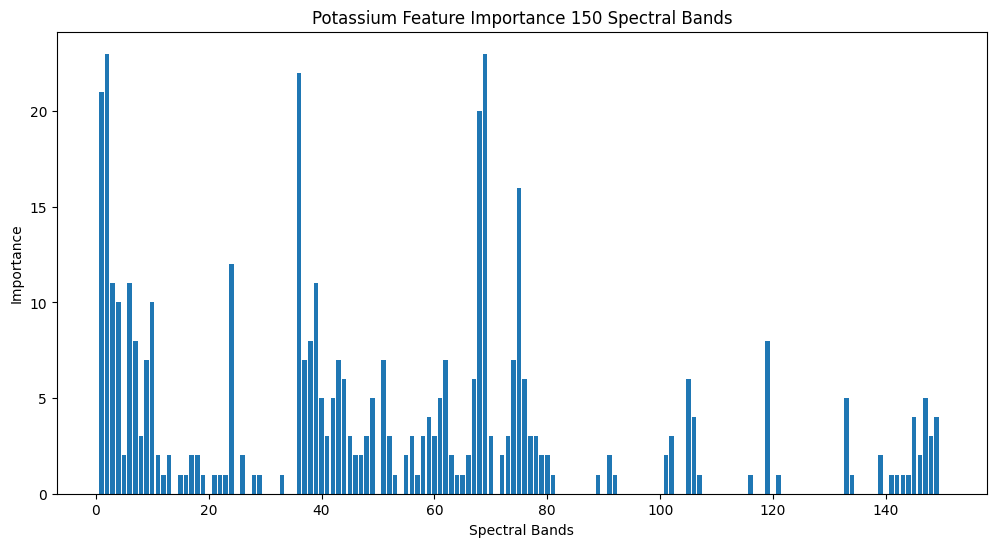

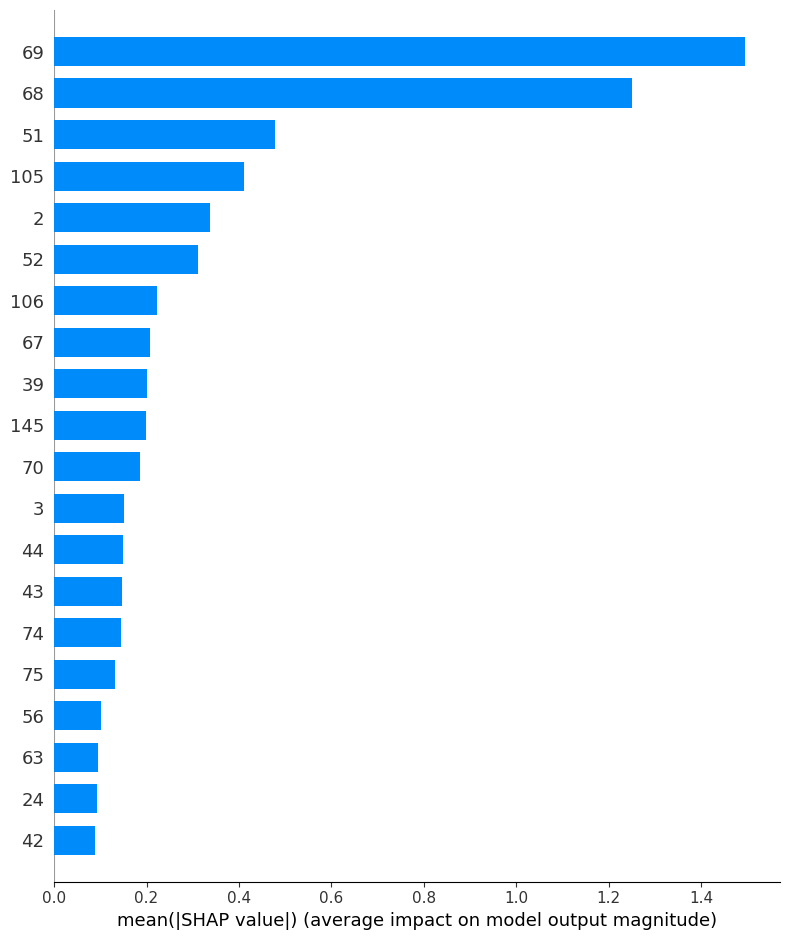

In [239]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample data for 150 spectral bands (you should replace this with your actual data)
spectral_bands = np.arange(1, 151)
K_feature_importance = K_best_model.feature_importances_  # Replace with your actual spectral band values

# Create a bar chart for feature importance
plt.figure(figsize=(12, 6))
plt.bar(spectral_bands, K_feature_importance, width=0.8, align='center')
plt.xlabel('Spectral Bands')
plt.ylabel('Importance')
plt.title('Potassium Feature Importance 150 Spectral Bands')
plt.show()

# Create an explainer for your model (replace 'P_best_model' with your actual model)
explainer = shap.Explainer(K_best_model)

# Calculate SHAP values for a specific instance (X_test[0] in this example)
input_data = X_test[0]

# Check the shape and reshape if necessary
if len(input_data.shape) == 1:
    input_data = input_data.reshape(1, -1)  # Reshape to 2D
shap_values = explainer.shap_values(input_data)

# Visualize the summary plot for feature importance
shap.summary_plot(shap_values, input_data, feature_names=spectral_bands, plot_type="bar")

# Visualize the force plot for the expected value (no need for [0])
shap.initjs()  # Required to display the plot in Jupyter Notebook
shap.force_plot(explainer.expected_value, shap_values, input_data)


### Magnesium Model

In [240]:
Mg_test=[]
# Create LightGBM datasets for training and testing
train_data = lgb.Dataset(X_train, label=Mg_train)
test_data = lgb.Dataset(X_test, label=Mg_test)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'objective': ['regression'],  # Multi-output regression task
    'num_leaves': [3,7,12],
    'learning_rate': [0.01,0.03,0.05],
    'n_estimators': [10,20,40],
    'max_depth': [5,7,9],
    'reg_alpha':[0.1,0.3,0.5],
    'reg_lambda':[0.1,0.2,0.3],
    'feature_fraction': [0.6,0.75,0.9],  
    'bagging_fraction': [0.6,0.75,0.9],
    'bagging_freq':[1,3,5,7,10],
    'min_child_samples': [20,50,100],
    'boosting_type': ['gbdt', 'dart','goss']  
}
# Create the LGBMRegressor model
model = lgb.LGBMRegressor()

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, scoring='neg_mean_squared_error', cv=50, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV
random_search.fit(X_train, Mg_train)

# Get the best estimator from RandomizedSearchCV
Mg_best_model = random_search.best_estimator_

# Make predictions on the test data
Mg_pred = Mg_best_model.predict(X_test)


#Best Parameters: {'reg_lambda': 0.3, 'reg_alpha': 0.5, 'objective': 'regression', 'num_leaves': 12, 'n_estimators': 20, 'min_child_samples': 100, 'max_depth': 5, 'learning_rate': 0.05, 'feature_fraction': 0.75, 'boosting_type': 'gbdt', 'bagging_freq': 3, 'bagging_fraction': 0.75}

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample

KeyboardInterrupt: 

In [102]:
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'reg_lambda': 0.3, 'reg_alpha': 0.5, 'objective': 'regression', 'num_leaves': 12, 'n_estimators': 20, 'min_child_samples': 100, 'max_depth': 5, 'learning_rate': 0.05, 'feature_fraction': 0.75, 'boosting_type': 'gbdt', 'bagging_freq': 3, 'bagging_fraction': 0.75}


In [103]:
Mg_pred=pd.DataFrame(Mg_pred,columns=["Mg"])
Mg_pred.columns = ["Mg"]

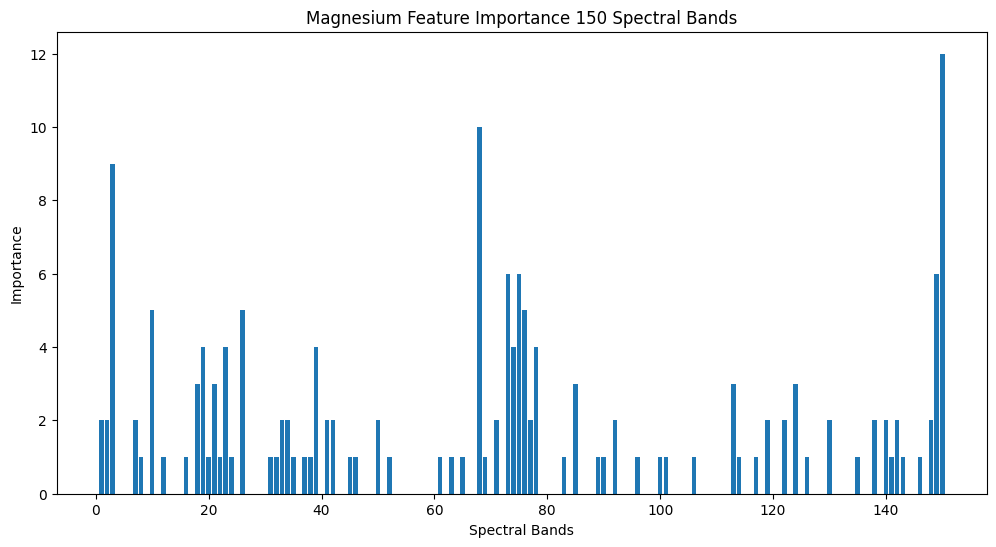

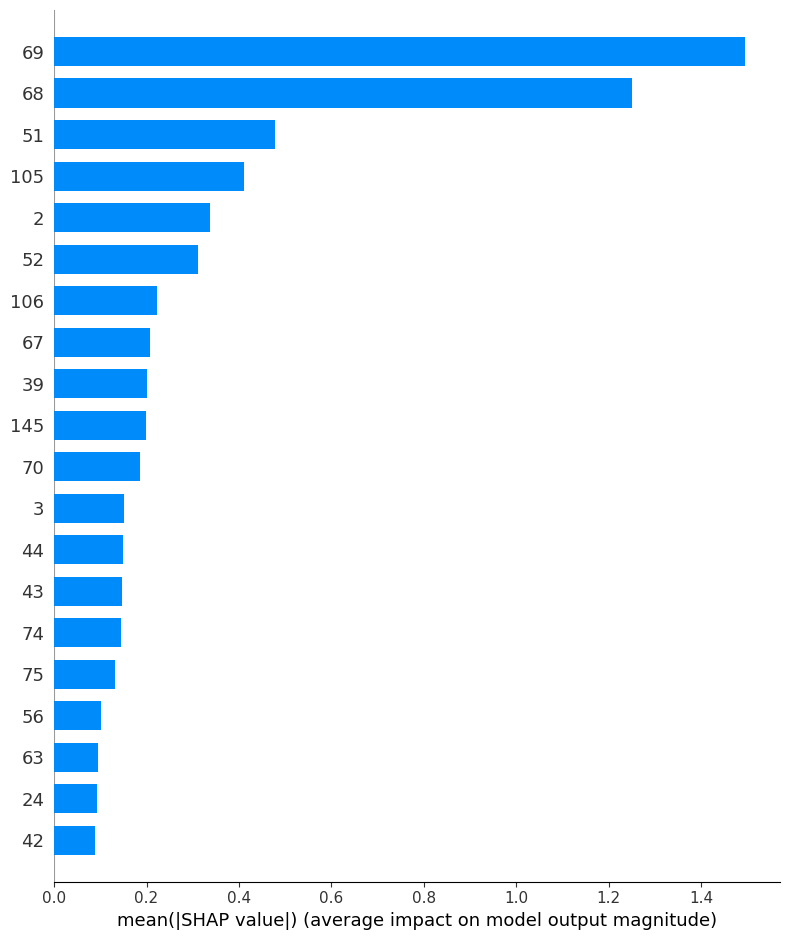

In [241]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample data for 150 spectral bands (you should replace this with your actual data)
spectral_bands = np.arange(1, 151)
Mg_feature_importance = Mg_best_model.feature_importances_  # Replace with your actual spectral band values

# Create a bar chart for feature importance
plt.figure(figsize=(12, 6))
plt.bar(spectral_bands, Mg_feature_importance, width=0.8, align='center')
plt.xlabel('Spectral Bands')
plt.ylabel('Importance')
plt.title('Magnesium Feature Importance 150 Spectral Bands')
plt.show()

# Create an explainer for your model (replace 'P_best_model' with your actual model)
explainer = shap.Explainer(Mg_best_model)

# Calculate SHAP values for a specific instance (X_test[0] in this example)
input_data = X_test[0]

# Check the shape and reshape if necessary
if len(input_data.shape) == 1:
    input_data = input_data.reshape(1, -1)  # Reshape to 2D
Mg_shap_values = explainer.shap_values(input_data)

# Visualize the summary plot for feature importance
shap.summary_plot(shap_values, input_data, feature_names=spectral_bands, plot_type="bar")

# Visualize the force plot for the expected value (no need for [0])
shap.initjs()  # Required to display the plot in Jupyter Notebook
shap.force_plot(explainer.expected_value, shap_values, input_data)


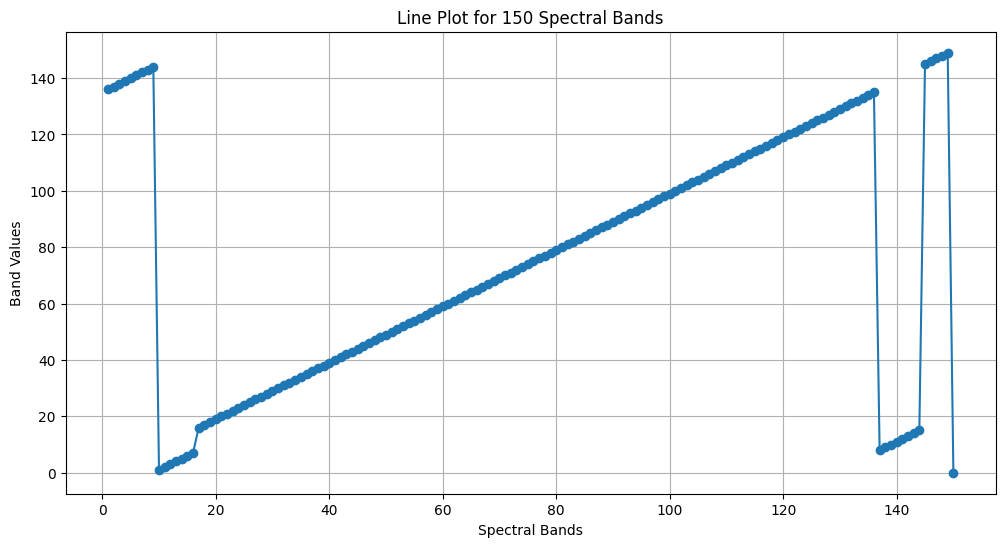

In [143]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for 150 spectral bands (you should replace this with your actual data)
spectral_bands
Mg_interactions = shap.approximate_interactions(1, Mg_shap_values, input_data, spectral_bands)

# Create a line plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(spectral_bands, Mg_interactions, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Spectral Bands')
plt.ylabel('Band Values')
plt.title('Line Plot for 150 Spectral Bands')

# Show the chart
plt.grid()  # Add grid lines if needed
plt.show()


### pH Test

In [ ]:
pH_test=[]
# Create LightGBM datasets for training and testing
train_data = lgb.Dataset(X_train, label=pH_train)
test_data = lgb.Dataset(X_test, label=pH_test)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'objective': ['regression'],  # Multi-output regression task
    'num_leaves': [3,7,12],
    'learning_rate': [0.01,0.03,0.05],
    'n_estimators': [10,20,40],
    'max_depth': [5,7,9],
    'reg_alpha':[0.1,0.3,0.5],
    'reg_lambda':[0.1,0.2,0.3],
    'feature_fraction': [0.6,0.75,0.9],  
    'bagging_fraction': [0.6,0.75,0.9],
    'bagging_freq':[1,3,5,7,10],
    'min_child_samples': [20,50,100],
    'boosting_type': ['gbdt', 'dart','goss']  
}

# Create the LGBMRegressor model
model = lgb.LGBMRegressor()

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=100, scoring='neg_mean_squared_error', cv=50, n_jobs=-1, random_state=42, verbose=0)

# Fit the RandomizedSearchCV
random_search.fit(X_train, pH_train)

# Get the best estimator from RandomizedSearchCV
pH_best_model = random_search.best_estimator_

# Make predictions on the test data
pH_pred = pH_best_model.predict(X_test)


#Best Parameters: {'reg_lambda': 0.2, 'reg_alpha': 0.3, 'objective': 'regression', 'num_leaves': 12, 'n_estimators': 40, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.05, 'feature_fraction': 0.75, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'bagging_fraction': 0.9}

In [106]:
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'reg_lambda': 0.2, 'reg_alpha': 0.3, 'objective': 'regression', 'num_leaves': 12, 'n_estimators': 40, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.05, 'feature_fraction': 0.75, 'boosting_type': 'gbdt', 'bagging_freq': 1, 'bagging_fraction': 0.9}


In [107]:
pH_pred=pd.DataFrame(pH_pred)
pH_pred.columns = ["pH"]

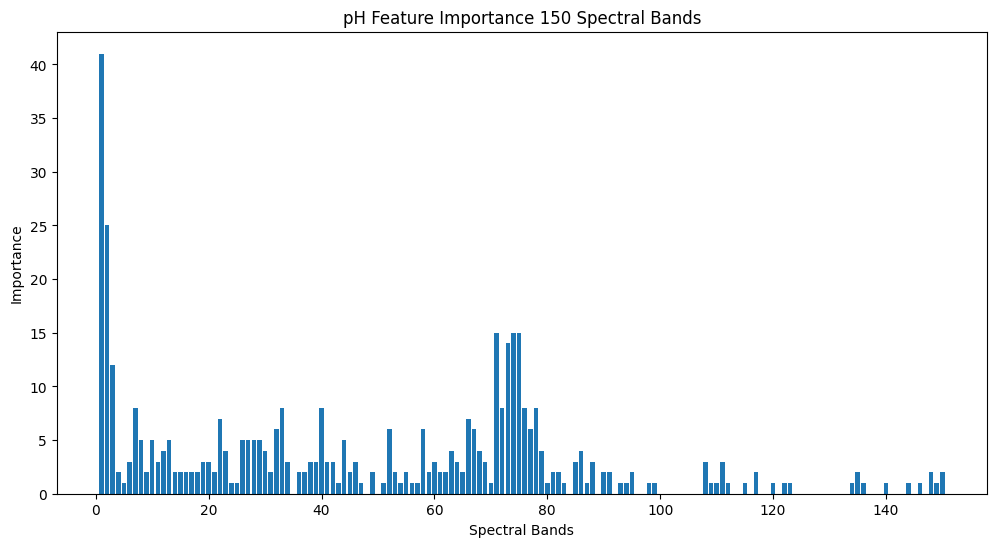

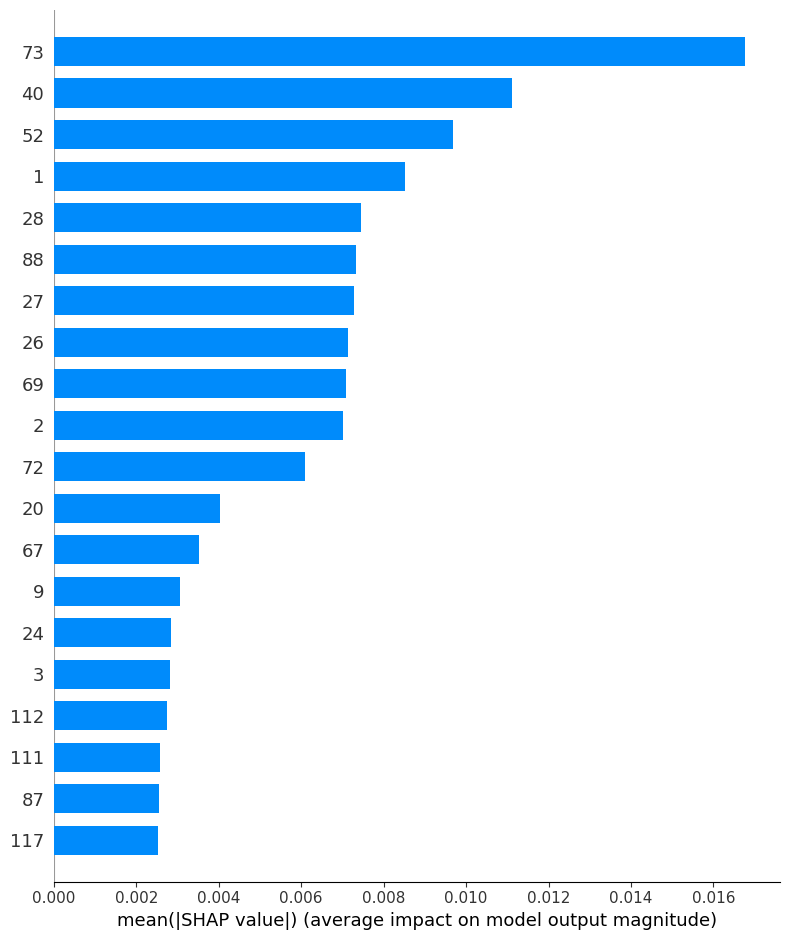

In [140]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample data for 150 spectral bands (you should replace this with your actual data)
spectral_bands = np.arange(1, 151)
pH_feature_importance = pH_best_model.feature_importances_  # Replace with your actual spectral band values

# Create a bar chart for feature importance
plt.figure(figsize=(12, 6))
plt.bar(spectral_bands, pH_feature_importance, width=0.8, align='center')
plt.xlabel('Spectral Bands')
plt.ylabel('Importance')
plt.title('pH Feature Importance 150 Spectral Bands')
plt.show()

# Create an explainer for your model (replace 'P_best_model' with your actual model)
explainer = shap.Explainer(pH_best_model)

# Calculate SHAP values for a specific instance (X_test[0] in this example)
input_data = X_test[0]

# Check the shape and reshape if necessary
if len(input_data.shape) == 1:
    input_data = input_data.reshape(1, -1)  # Reshape to 2D
shap_values = explainer.shap_values(input_data)

# Visualize the summary plot for feature importance
shap.summary_plot(shap_values, input_data, feature_names=spectral_bands, plot_type="bar")

# Visualize the force plot for the expected value (no need for [0])
shap.initjs()  # Required to display the plot in Jupyter Notebook
shap.force_plot(explainer.expected_value, shap_values, input_data)


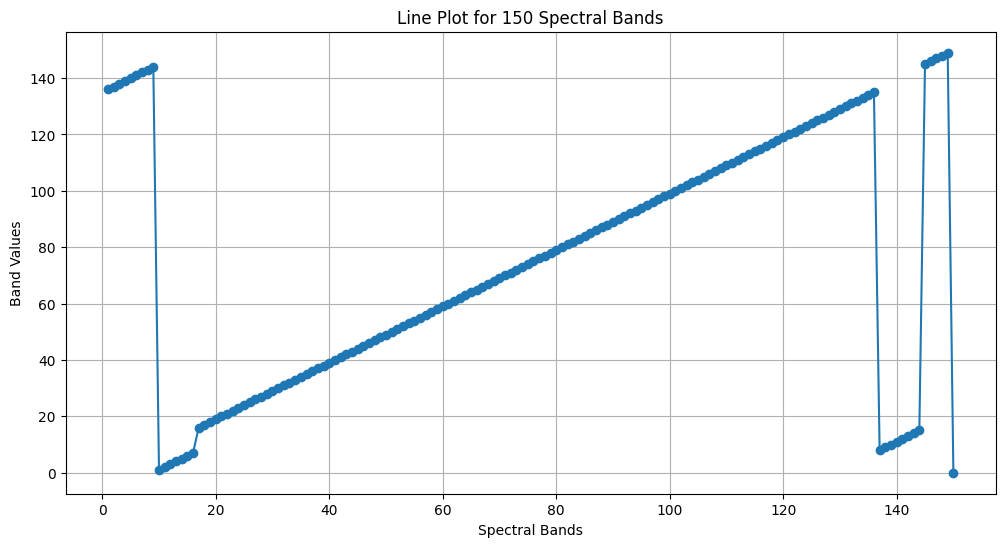

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for 150 spectral bands (you should replace this with your actual data)
spectral_bands
interactions = shap.approximate_interactions(1, shap_values, input_data, spectral_bands)

# Create a line plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(spectral_bands, interactions, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Spectral Bands')
plt.ylabel('Band Values')
plt.title('Line Plot for 150 Spectral Bands')

# Show the chart
plt.grid()  # Add grid lines if needed
plt.show()


In [109]:
Y_pred = P_pred.join(K_pred.join(Mg_pred.join(pH_pred)))
Y_pred

,P,K,Mg,pH
0,69.533960,222.559913,159.616028,6.840091
1,69.479065,230.368592,164.058723,6.833208
2,71.123263,227.055263,167.294819,6.874343
3,69.479065,227.097988,161.206084,6.832061
4,69.088889,223.886486,159.041104,6.876843
...,...,...,...,...
1149,69.088889,227.580811,162.127483,6.696004
1150,69.088889,227.851755,161.960191,6.652760
1151,69.340396,223.842659,165.387215,6.835263
1152,69.088889,226.044655,161.960191,6.631440


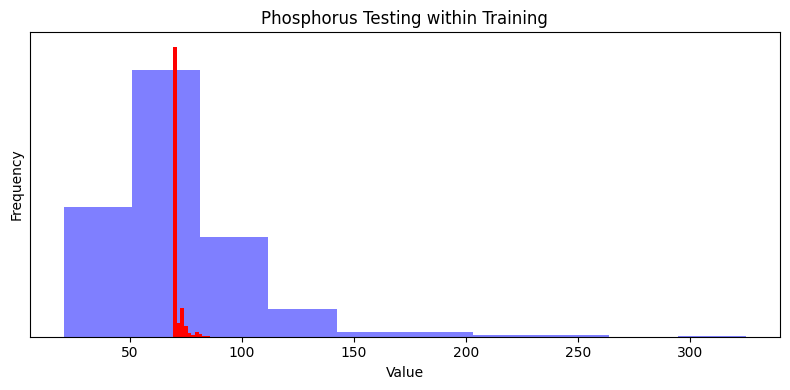

In [221]:
import matplotlib.pyplot as plt

# Create a single figure with two subplots side by side and share the y-axis
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(y_train['P'], bins=10, color='b', alpha=0.5, label='P Train')
ax.hist(P_pred, bins=10, color='r', label='P Test')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Phosphorus Testing within Training')
ax.set_yticks([])

plt.tight_layout()
plt.show()


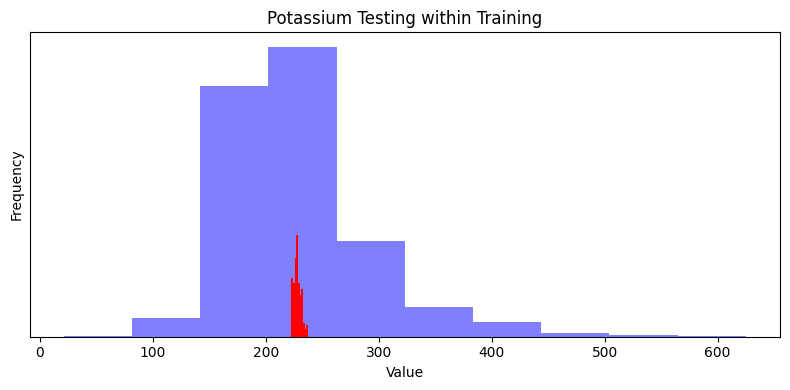

In [222]:
# Create a single figure with two subplots side by side and share the y-axis
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(y_train['K'], bins=10, color='b', alpha=0.5, label='K Train')
ax.hist(K_pred, bins=10, color='r', label='K Test')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Potassium Testing within Training')
ax.set_yticks([])

plt.tight_layout()
plt.show()

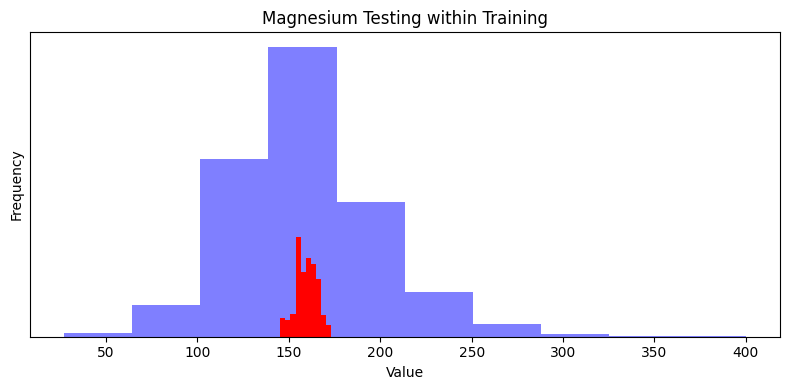

In [223]:
# Create a single figure with two subplots side by side and share the y-axis
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(y_train['Mg'], bins=10, color='b', alpha=0.5, label='Mg Train')
ax.hist(Mg_pred, bins=10, color='r', label='Mg Test')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Magnesium Testing within Training')
ax.set_yticks([])

plt.tight_layout()
plt.show()

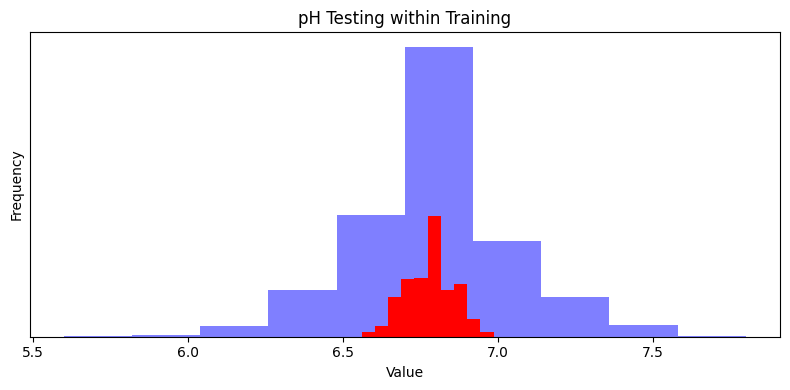

In [224]:
# Create a single figure with two subplots side by side and share the y-axis
fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(y_train['pH'], bins=10, color='b', alpha=0.5, label='pH Train')
ax.hist(pH_pred, bins=10, color='r', label='pH Test')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('pH Testing within Training')
ax.set_yticks([])

plt.tight_layout()
plt.show()

## Old model, basic, not optimized

In [110]:
#Match index with Sample ID Numbers in filename
directory = '/Users/nathanzlomke/Downloads/test_data'
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
sample_nums = []
for file_name in files:
    file_name = file_name.replace('.npz','')
    sample_nums.append(file_name)
print(sample_nums)

['77', '837', '189', '63', '823', '638', '610', '88', '176', '162', '604', '1145', '1151', '348', '374', '412', '406', '360', '599', '1019', '1031', '1025', '228', '200', '566', '572', '214', '943', '957', '758', '980', '994', '764', '770', '771', '765', '995', '981', '759', '956', '942', '573', '215', '201', '567', '229', '1024', '1030', '1018', '598', '407', '361', '375', '413', '349', '1150', '1144', '163', '605', '89', '611', '177', '639', '822', '62', '836', '76', '188', '60', '820', '74', '834', '48', '808', '149', '607', '161', '175', '613', '388', '1152', '1146', '439', '363', '405', '411', '377', '1026', '1032', '559', '217', '571', '565', '203', '954', '940', '798', '968', '997', '983', '773', '767', '766', '772', '982', '996', '969', '799', '941', '955', '564', '202', '216', '570', '558', '1033', '1027', '410', '376', '362', '404', '438', '1147', '1153', '389', '174', '612', '606', '160', '148', '809', '49', '835', '75', '821', '61', '59', '819', '65', '825', '71', '831', '1

In [111]:
#Add header names
predictionsDF = pd.DataFrame(data = Y_pred, columns= ['P','K','Mg','pH'])
#Change index to sample number
predictionsDF.index = sample_nums
predictionsDF.head()


,P,K,Mg,pH
77,69.533960,222.559913,159.616028,6.840091
837,69.479065,230.368592,164.058723,6.833208
189,71.123263,227.055263,167.294819,6.874343
63,69.479065,227.097988,161.206084,6.832061
823,69.088889,223.886486,159.041104,6.876843


In [112]:
#scale predictions by baseline regressor values for submission
baseline_values = pd.read_csv('/Users/nathanzlomke/Downloads/baseline_regressor_values.csv')
baseline_values = baseline_values.drop(columns='sample_index')
baseline_values.head()


,P,K,Mg,pH
0,70.302656,227.98851,159.281236,6.782719
1,70.302656,227.98851,159.281236,6.782719
2,70.302656,227.98851,159.281236,6.782719
3,70.302656,227.98851,159.281236,6.782719
4,70.302656,227.98851,159.281236,6.782719


In [113]:
scaled_predictions = Y_pred / baseline_values
scaled_predictions.head()


,P,K,Mg,pH
0,0.989066,0.976189,1.002102,1.008458
1,0.988285,1.010439,1.029994,1.007444
2,1.011672,0.995907,1.050311,1.013508
3,0.988285,0.996094,1.012085,1.007275
4,0.982735,0.982008,0.998492,1.013877


In [114]:
#Make into singular column format and output submission file
#P_df = pd.DataFrame(P_df)
P_df = scaled_predictions.iloc[:,0]
P_index = predictionsDF.index.astype(str)+'_P'


#K_df = pd.DataFrame(K_df)
K_df = scaled_predictions.iloc[:,1]
K_index = predictionsDF.index.astype(str)+'_K'

#Mg_df = pd.DataFrame(Mg_df)
Mg_df = scaled_predictions.iloc[:,2]
Mg_index = predictionsDF.index.astype(str)+'_Mg'

#pH_df = pd.DataFrame(pH_df)
pH_df = scaled_predictions.iloc[:,3]
pH_index = predictionsDF.index.astype(str)+'_pH'

sample_index=[]
for i in range(len(P_index)):
    sample_index.append(P_index[i])
    sample_index.append(K_index[i])
    sample_index.append(Mg_index[i])
    sample_index.append(pH_index[i])
sample_index

['77_P',
 '77_K',
 '77_Mg',
 '77_pH',
 '837_P',
 '837_K',
 '837_Mg',
 '837_pH',
 '189_P',
 '189_K',
 '189_Mg',
 '189_pH',
 '63_P',
 '63_K',
 '63_Mg',
 '63_pH',
 '823_P',
 '823_K',
 '823_Mg',
 '823_pH',
 '638_P',
 '638_K',
 '638_Mg',
 '638_pH',
 '610_P',
 '610_K',
 '610_Mg',
 '610_pH',
 '88_P',
 '88_K',
 '88_Mg',
 '88_pH',
 '176_P',
 '176_K',
 '176_Mg',
 '176_pH',
 '162_P',
 '162_K',
 '162_Mg',
 '162_pH',
 '604_P',
 '604_K',
 '604_Mg',
 '604_pH',
 '1145_P',
 '1145_K',
 '1145_Mg',
 '1145_pH',
 '1151_P',
 '1151_K',
 '1151_Mg',
 '1151_pH',
 '348_P',
 '348_K',
 '348_Mg',
 '348_pH',
 '374_P',
 '374_K',
 '374_Mg',
 '374_pH',
 '412_P',
 '412_K',
 '412_Mg',
 '412_pH',
 '406_P',
 '406_K',
 '406_Mg',
 '406_pH',
 '360_P',
 '360_K',
 '360_Mg',
 '360_pH',
 '599_P',
 '599_K',
 '599_Mg',
 '599_pH',
 '1019_P',
 '1019_K',
 '1019_Mg',
 '1019_pH',
 '1031_P',
 '1031_K',
 '1031_Mg',
 '1031_pH',
 '1025_P',
 '1025_K',
 '1025_Mg',
 '1025_pH',
 '228_P',
 '228_K',
 '228_Mg',
 '228_pH',
 '200_P',
 '200_K',
 '200_

In [115]:
outputCSV = []
#If running newer Python 3.11, this append converts the dF into a list format and needs to be converted back to dF with indexing
for i in range(len(pH_df)):
    outputCSV.append(P_df[i])
    outputCSV.append(K_df[i])
    outputCSV.append(Mg_df[i])
    outputCSV.append(pH_df[i])
outputCSV = pd.DataFrame(outputCSV)

In [116]:
outputCSV.index = sample_index
outputCSV = outputCSV.rename(columns={0: 'Target'})

outputCSV.head()

,Target
77_P,0.989066
77_K,0.976189
77_Mg,1.002102
77_pH,1.008458
837_P,0.988285


In [117]:
outputCSV.to_csv("/Users/nathanzlomke/Downloads/LightGBM_optimized_output9.csv", index_label='sample_index')

## Output Indexing Prep

In [123]:
#Match index with Sample ID Numbers in filename
directory = '/Users/nathanzlomke/Downloads/test_data'
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
sample_nums = []
for file_name in files:
    file_name = file_name.replace('.npz','')
    sample_nums.append(file_name)
print(sample_nums)

['77', '837', '189', '63', '823', '638', '610', '88', '176', '162', '604', '1145', '1151', '348', '374', '412', '406', '360', '599', '1019', '1031', '1025', '228', '200', '566', '572', '214', '943', '957', '758', '980', '994', '764', '770', '771', '765', '995', '981', '759', '956', '942', '573', '215', '201', '567', '229', '1024', '1030', '1018', '598', '407', '361', '375', '413', '349', '1150', '1144', '163', '605', '89', '611', '177', '639', '822', '62', '836', '76', '188', '60', '820', '74', '834', '48', '808', '149', '607', '161', '175', '613', '388', '1152', '1146', '439', '363', '405', '411', '377', '1026', '1032', '559', '217', '571', '565', '203', '954', '940', '798', '968', '997', '983', '773', '767', '766', '772', '982', '996', '969', '799', '941', '955', '564', '202', '216', '570', '558', '1033', '1027', '410', '376', '362', '404', '438', '1147', '1153', '389', '174', '612', '606', '160', '148', '809', '49', '835', '75', '821', '61', '59', '819', '65', '825', '71', '831', '1

In [124]:
#Add header names
predictionsDF = pd.DataFrame(data = predictions, columns= ['P','K','Mg','pH'])
#Change index to sample number
predictionsDF.index = sample_nums
predictionsDF.head()


,P,K,Mg,pH
77,-38.845940,175.392380,184.172974,71.859871
837,-29.952654,191.331680,195.483002,36.625034
189,-73.736176,192.993088,226.587387,91.633682
63,-80.022408,199.317413,258.022461,97.636978
823,54.666374,170.369308,85.061409,-66.881508


In [125]:
#scale predictions by baseline regressor values for submission
baseline_values = pd.read_csv('/Users/nathanzlomke/Downloads/baseline_regressor_values.csv')
baseline_values = baseline_values.drop(columns='sample_index')
baseline_values.head()


,P,K,Mg,pH
0,70.302656,227.98851,159.281236,6.782719
1,70.302656,227.98851,159.281236,6.782719
2,70.302656,227.98851,159.281236,6.782719
3,70.302656,227.98851,159.281236,6.782719
4,70.302656,227.98851,159.281236,6.782719


In [126]:
scaled_predictions = predictions / baseline_values
scaled_predictions.head()


,P,K,Mg,pH
0,-0.552553,0.769304,1.156275,10.594552
1,-0.426053,0.839216,1.227282,5.399757
2,-1.048839,0.846504,1.422562,13.509874
3,-1.138256,0.874243,1.619918,14.394961
4,0.777586,0.747271,0.534033,-9.860574


## Make predictions and generate submission file

In [127]:
baseline_reg = BaselineRegressor()
baseline_reg = baseline_reg.fit(X_train, y_train)
predictions = baseline_reg.predict(X_test)

submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("/Users/nathanzlomke/Downloads/submission.csv", index_label="sample_index")


## Calculating the metric

For the purpose of presenting the final metric calculation, we will extract a small _test_set_ from the training set.

In [128]:
X_test = X_train[1500:]
y_test = y_train[1500:]

X_train_new = X_train[:1500]
y_train_new = y_train[:1500]

# Fit the baseline regressor once again on new training set
baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
baseline_predictions = baseline_reg.predict(X_test)

# Generate baseline values to be used in score computation
baselines = np.mean((y_test - baseline_predictions) ** 2, axis=0)


# Generate random predictions, different from baseline predictions
np.random.seed(0)
predictions = np.zeros_like(y_test)
for column_index in range(predictions.shape[1]):
    class_mean_value = baseline_reg.mean[column_index]
    predictions[:, column_index] = np.random.uniform(low=class_mean_value - class_mean_value * 0.05,
                                                     high=class_mean_value + class_mean_value * 0.05,
                                                     size=len(predictions))

# Calculate MSE for each class
mse = np.mean((y_test - predictions) ** 2, axis=0)

# Calculate the score for each class individually
scores = mse / baselines

# Calculate the final score
final_score = np.mean(scores)

for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
    print(f"Class {class_name} score: {score}")

print(f"Final score: {final_score}")

Class P score: 0.9998753469340139
Class K score: 0.9997921231619824
Class Mg score: 0.9999078756523962
Class pH score: 0.9998941139750682
Final score: 0.9998673649308653
